In [1]:
!pip install --upgrade pip
!pip install cmake
!pip install face_recognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 118.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 104.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 97.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dlib: filename=dlib-19.24.6-cp310-cp310-linux_x86_64.whl size=3590658 sha256=891f732ca5b306fa3c4e627b2a704f109c9977355631dcf5f8a89668b5debbf2
  Stored in directory: /root/.cache/pip/wheels/7c/1d/d1/e69ceb001441acedfa6156acda6c1856699e260ea1a9e6dcc4
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566163 sha256=2d2da56bf5795ca4df9f08437209d5c915cd1c92eaa6

# import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import shutil
import face_recognition as fc
from sklearn.model_selection import train_test_split
from sklearn import neighbors
import sklearn.metrics as smt


# read the dataset

In [4]:
df = pd.read_csv('/kaggle/input/face-recognition-dataset/Dataset.csv')
df.head()

,id,label
0,Robert Downey Jr_87.jpg,Robert Downey Jr
1,Lisa Kudrow_64.jpg,Lisa Kudrow
2,Ellen Degeneres_34.jpg,Ellen Degeneres
3,Billie Eilish_3.jpg,Billie Eilish
4,Hrithik Roshan_35.jpg,Hrithik Roshan


# encode faces


In [5]:
def encode_images(df):
    dir = r'/kaggle/input/face-recognition-dataset/Original Images/Original Images'
    face_encodings_list = []
    labels_list = []
    for path, label in df.values:
        img_path = os.path.join(dir, label, path)
        image = fc.load_image_file(img_path)
        face_encodings = fc.face_encodings(image)

        if face_encodings:
            face_encoding = face_encodings[0]
            face_encodings_list.append(face_encoding)
            labels_list.append(label)
    return face_encodings_list, labels_list

In [6]:
x, y = encode_images(df)


# splitting the data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, stratify=y, random_state=42
)

# classification model

In [21]:
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', weights='distance')

In [22]:
knn_clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance')

# model evaluation

In [23]:
knn_clf.score(x_train, y_train)

1.0

In [24]:
y_pred = knn_clf.predict(x_test)
precision = smt.precision_score(y_test, y_pred, average='weighted')
recall = smt.recall_score(y_test, y_pred, average='weighted')
f1 = smt.f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# image predection

In [25]:
def show_image(image, x=10, y=8, bgr=False):
    plt.figure(figsize=(x, y))

    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    elif len(image.shape) == 3:
        if bgr:
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.imshow(image)

    plt.xticks([])
    plt.yticks([])
    plt.show()

In [27]:
def predict_and_visualize(image_path):
    # Read the image
    image = cv.imread(image_path)
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_height, image_width = image.shape[:2]

    # Predict
    face_locations = fc.face_locations(rgb_image)
    face_encodings = fc.face_encodings(rgb_image, face_locations)

    # Visualize
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):

        matches = knn_clf.kneighbors([face_encoding], n_neighbors=1)
        name = knn_clf.predict([face_encoding])[0] if matches[0][0][0] < 0.5 else "Unknown"
        
        cv.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
        font_scale = image_width / 700.0  
        text_position = (left, bottom + int(image_height * 0.06)) 
        cv.putText(image, name, text_position, cv.FONT_HERSHEY_DUPLEX, font_scale, (0, 255, 0), 2)

    show_image(image, bgr=True)

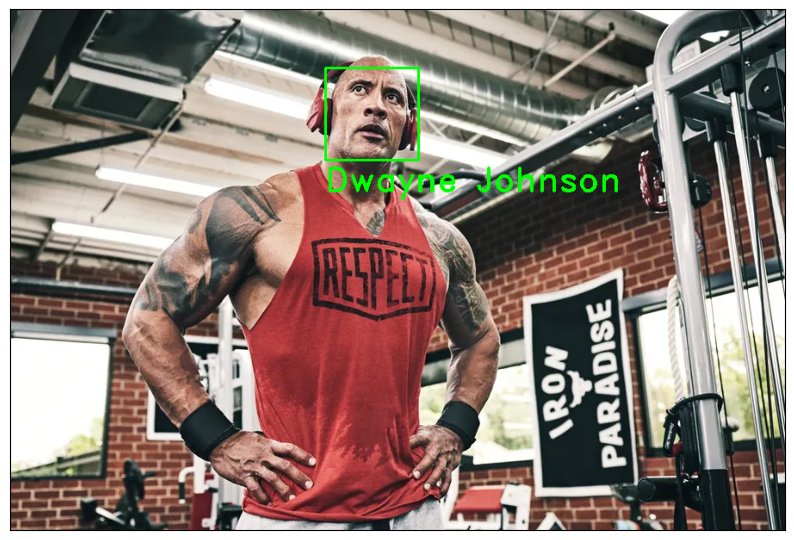

In [28]:
img = '/kaggle/input/images/the-rock-project-rock-respect-bo8k669j2xtbay1c.jpg'
predict_and_visualize(img)